In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = 'data/dogbreeds/'

In [5]:
sz=220

### Load Data

In [6]:
df = pd.read_csv(PATH+'labels.csv')

In [7]:
df.columns

Index(['id', 'breed'], dtype='object')

In [8]:
df['id'].size

10222

In [16]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


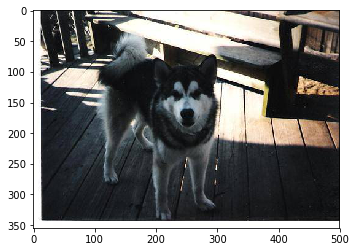

In [15]:
plt.imshow(plt.imread(f'{PATH}train/933e245251bc667ce6ff74f12dc998fe.jpg'))

data/dogbreeds/train/000bec180eb18c7604dcecc8fe0dba07.jpg


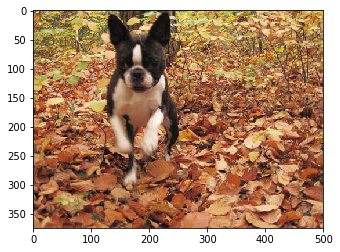

In [9]:
test_file = PATH+'train/'+df['id'][0]+'.jpg'
print(test_file)
test_img = plt.imread(test_file)
plt.imshow(test_img)
# PIL.Image.open(test_file)

In [10]:
size_map = { k:plt.imread(f'{PATH}train/{k}.jpg').shape for k in df['id'][1:]}

In [11]:
size_map

{'001513dfcb2ffafc82cccf4d8bbaba97': (375, 500, 3),
 '001cdf01b096e06d78e9e5112d419397': (375, 500, 3),
 '00214f311d5d2247d5dfe4fe24b2303d': (344, 400, 3),
 '0021f9ceb3235effd7fcde7f7538ed62': (500, 500, 3),
 '002211c81b498ef88e1b40b9abf84e1d': (375, 500, 3),
 '00290d3e1fdd27226ba27a8ce248ce85': (470, 500, 3),
 '002a283a315af96eaea0e28e7163b21b': (227, 231, 3),
 '003df8b8a8b05244b1d920bb6cf451f9': (500, 474, 3),
 '0042188c895a2f14ef64a918ed9c7b64': (332, 500, 3),
 '004396df1acd0f1247b740ca2b14616e': (500, 375, 3),
 '0067dc3eab0b3c3ef0439477624d85d6': (343, 402, 3),
 '00693b8bc2470375cc744a6391d397ec': (299, 500, 3),
 '006cc3ddb9dc1bd827479569fcdc52dc': (223, 250, 3),
 '0075dc49dab4024d12fafe67074d8a81': (332, 500, 3),
 '00792e341f3c6eb33663e415d0715370': (192, 200, 3),
 '007b5a16db9d9ff9d7ad39982703e429': (212, 374, 3),
 '007b8a07882822475a4ce6581e70b1f8': (500, 333, 3),
 '007ff9a78eba2aebb558afea3a51c469': (375, 500, 3),
 '008887054b18ba3c7601792b6a453cc3': (160, 160, 3),
 '008b1271ed

In [12]:
h, w, ch = list(zip(*size_map.values()))

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<600])

### Architecture

In [ ]:
!rm -rf {PATH}tmp

In [18]:
arch=resnet34

In [19]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = df['id'].size-1
val_idxs = get_cv_idxs(n)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=f'{PATH}labels.csv', test_name='test', tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
new_data = data.resize(sz, 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [26]:
data.trn_ds[0][0].shape

(3, 220, 220)

In [27]:
learn = ConvLearner.pretrained(arch, data=new_data, precompute=True)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [28]:
learn.fit(lrs=1e-1, n_cycle=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.36352    0.739214   0.766211  
    1      0.87057    0.820428   0.774935                    



[0.82042783, 0.774934895336628]

In [ ]:
learn.fit(lrs=1e-2, n_cycle=2)

In [ ]:
learn.precompute=False

In [ ]:
learn.fit(lrs=1e-2, n_cycle=3)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_len=1)

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_mult=2)

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

In [ ]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)